In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
!pip install kneed
from kneed import KneeLocator

# Exercise 1: Clustering Method

In this exercise we will explore how each clustering algorithm discussed in the class works.

## Load Dataset

The dataset that we will use is a customer transaction in a certain mall. In this dataset there will 4 features including Gender, Age, Annual Income, and Spending Score. You can get the dataset from https://raw.githubusercontent.com/NathaliaMinoque/dataset/refs/heads/main/mall_customers.csv

In [8]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/dataset/refs/heads/main/mall_customers.csv"
df = pd.read_csv(url)
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
# rename the Annual Income (k$)	Spending Score (1-100) column
df = df.rename(columns={'Annual Income (k$)': 'AnnualIncome', 'Spending Score (1-100)': 'SpendingScore'})
df.head()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
# describe data
df.describe()

,CustomerID,Age,AnnualIncome,SpendingScore
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [11]:
# Check for null values in the dataset
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
AnnualIncome,0
SpendingScore,0


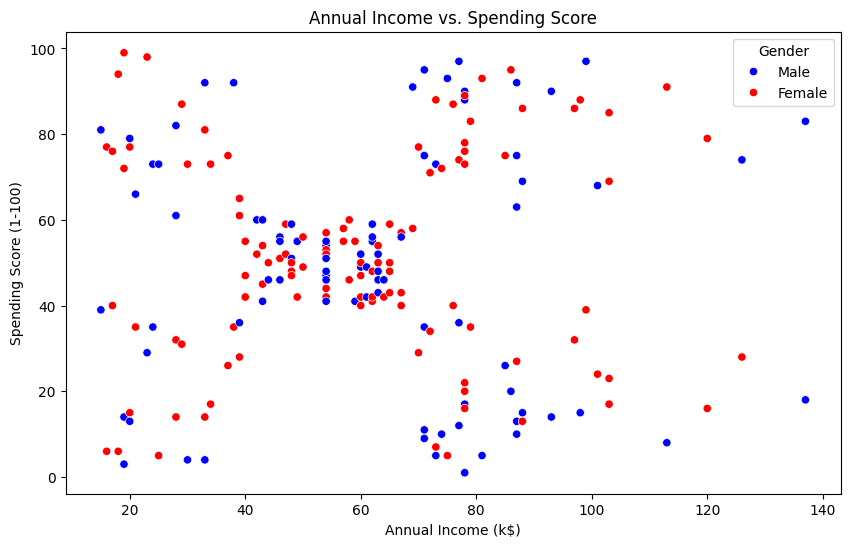

In [14]:
# make an insightful visualization and explain
# visualize the relationship between Annual Income and Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AnnualIncome', y='SpendingScore', data=df, hue='Gender', palette=['blue', 'red'])
plt.title('Annual Income vs. Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

# Explanation:
# This scatter plot shows the relationship between annual income and spending score, colored by gender(blue for male, red for female).
# This visualization is useful for consumer segmentation, especially in creating targeted marketing strategies.
# The gender distinction helps to see if there's any noticeable difference in spending patterns between males and females.
# There are distinct clusters, such as high-spending individuals with both low and high incomes and a dense group with middle income and moderate spending scores.
# A dense concentration is seen among middle-income individuals with moderate spending scores (around 40-60), reflecting common spending behavior in this income bracket.
# Gender does not significantly influence spending patterns, as both males and females are distributed evenly across income and spending levels. This suggests that other factors, like lifestyle or financial goals, may play a larger role in spending behavior.


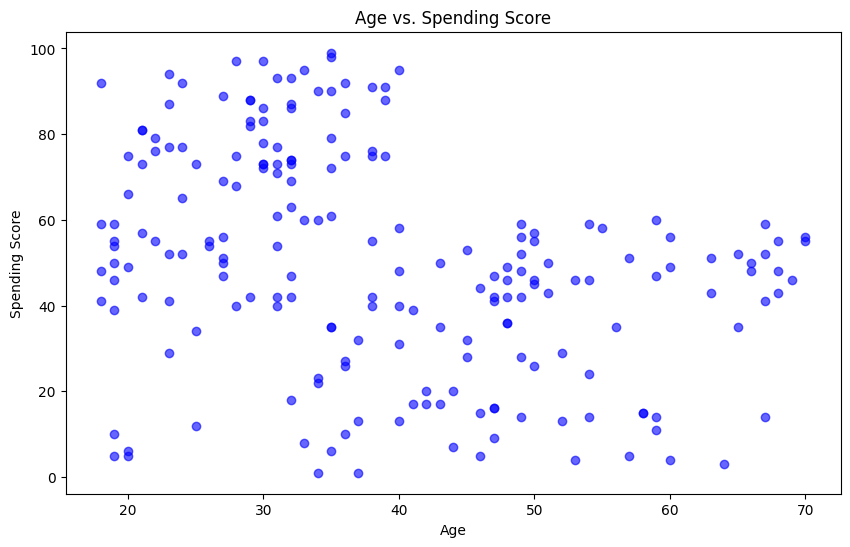

In [16]:
# make an insightful visualization and explain
plt.figure(figsize=(10, 6))
plt.scatter(df['Age'], df['SpendingScore'], color='blue', alpha=0.6)
plt.title('Age vs. Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.show()

# Explanation:
# This scatter plot shows the relationship between Age and Spending Score.
# Young Customers (20-30): Wide range in spending scores, from low to high, indicating varied spending habits.
# Middle-aged Customers (30-50): Mostly moderate spending, with scores clustering around the middle range.
# Older Customers (50+): Generally has lower spending scores, with fewer high spenders.
# These results suggest that age may influence spending habits, with younger customers showing more varied spending patterns compared to other age groups.

## Data Preprocessing

For this case study, we only use income and spending score

In [18]:
# create new dataframe that consist only annual income and spending score
new_df = df[['AnnualIncome', 'SpendingScore']]
new_df.head()

,AnnualIncome,SpendingScore
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


Before we analyze our data, we need to scale the data. You can use MinMaxScaler or StandardScaler.

In [20]:
# scale dataset with standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(new_df)
scaled_df = pd.DataFrame(scaled_df, columns = ['income', 'spending'])
scaled_df.head()

,income,spending
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


In [21]:
# get stastical information on the new dataset
scaled_df.describe()

,income,spending
count,2.000000e+02,2.000000e+02
mean,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00
min,-1.738999e+00,-1.910021e+00
25%,-7.275093e-01,-5.997931e-01
50%,3.587926e-02,-7.764312e-03
75%,6.656748e-01,8.851316e-01
max,2.917671e+00,1.894492e+00


Then, we check the inisial position for our sample. You may use pairplot or scattered chart for the visualization option.

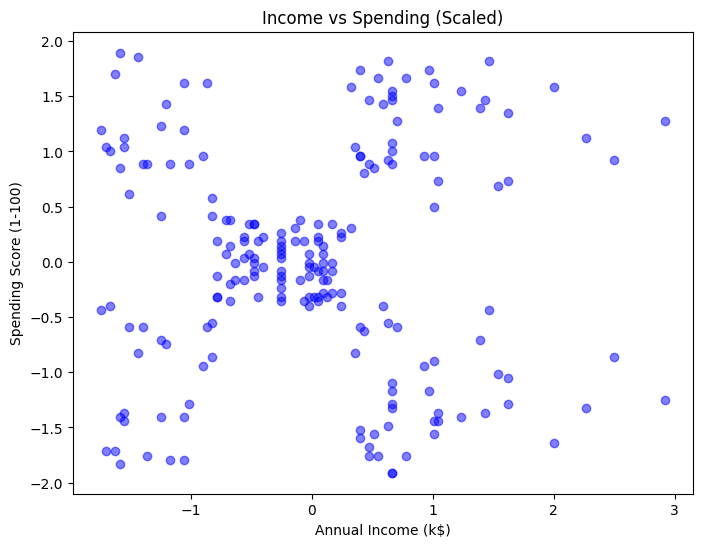

In [23]:
# Visualize the position
plt.figure(figsize=(8, 6))
plt.scatter(scaled_df['income'], scaled_df['spending'], color='blue', alpha=0.5)
plt.title('Income vs Spending (Scaled)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

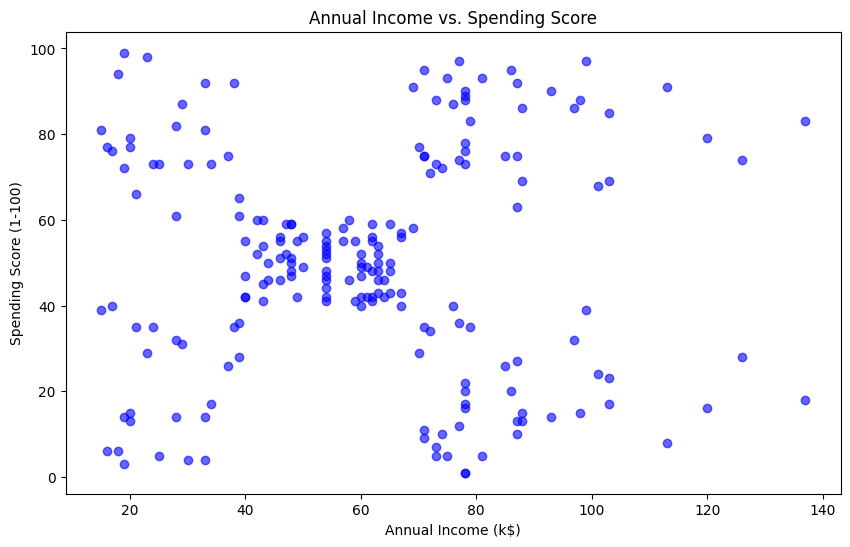

In [26]:
# Visualize the position using the original scale
# Inverse transform to get back to the original scale
plt.figure(figsize=(10, 6))
plt.scatter(df['AnnualIncome'], df['SpendingScore'], color='blue', alpha=0.6)
plt.title('Annual Income vs. Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

## Clustering

The evaluation for chosing the number of K in KMEANS can be done by several methods such as elbow method.

1. using elbow method
In this case study, the below parameter settings is used:
- init: random
- range: (1,11)
- max_iter: 300
- random state: 42

In [27]:
# set the parameter for evaluating K
from sklearn.cluster import KMeans
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='random', max_iter=300, random_state=42)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

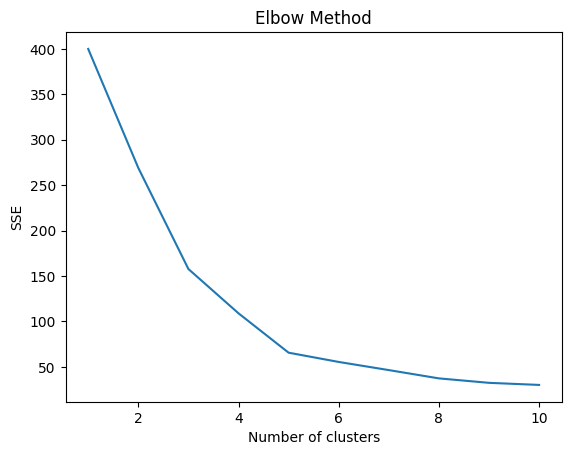

In [28]:
# manually visualize the elbow method using plotlib
plt.plot(range(1, 11), sse)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [29]:
# using kneelocator to find the elbow/knee
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve='convex', direction='decreasing')
print ("The best k for your model is", kl.elbow)

The best k for your model is 5


### K-Means Algorithm

For using KMeans clustering algorithm, you need to define the number of cluster, initialization number, number of iteration, and random state.

In this case study, the below parameter settings is used:
- centroid initialization: random
- number of cluster: 5
- number of iteration: 300
- random state: 42

In [30]:
# assign cluster with K-Means algorithm
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, init='random', max_iter=300, random_state=42)
y_pred= kmeans.fit_predict(scaled_df)
y_pred

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4,
       0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 4, 3, 2, 3, 2, 3,
       4, 3, 2, 3, 2, 3, 2, 3, 2, 3, 4, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3], dtype=int32)

Visualize your result based on income and spending. You also can show the final position of the centroid.

Text(0, 0.5, 'Spending')

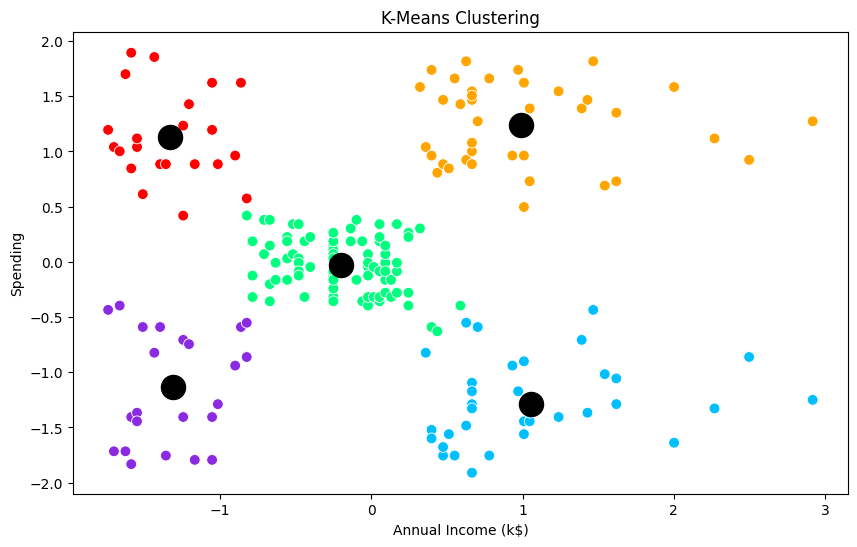

In [31]:
# visualize the result using scater chart
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_df, x='income', y='spending', hue=y_pred, palette=['blueviolet','red','deepskyblue','orange','springgreen'], legend =None, s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=300, label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending')

In [33]:
# Inverse transform the scaled data to get the original values
df= pd.DataFrame(scaler.inverse_transform(scaled_df), columns=['AnnualIncome', 'SpendingScore'])
df['Cluster'] = y_pred
df.head()

,AnnualIncome,SpendingScore,Cluster
0,15.0,39.0,0
1,15.0,81.0,1
2,16.0,6.0,0
3,16.0,77.0,1
4,17.0,40.0,0


In [37]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df.groupby(y_pred).agg({'SpendingScore': ['mean','std','min','max'], 'AnnualIncome': ['mean','std','min','max']})
cluster_summary= cluster_summary.rename_axis('Cluster')
cluster_summary

SpendingScore                        AnnualIncome                   \
                 mean        std   min   max         mean        std   min   
Cluster                                                                      
0           20.913043  13.017167   3.0  40.0    26.304348   7.893811  15.0   
1           79.363636  10.504174  61.0  99.0    25.727273   7.566731  15.0   
2           17.114286   9.952154   1.0  39.0    88.200000  16.399067  70.0   
3           82.128205   9.364489  63.0  97.0    86.538462  16.312485  69.0   
4           49.518519   6.530909  34.0  61.0    55.296296   8.988109  39.0   

                
           max  
Cluster         
0         39.0  
1         39.0  
2        137.0  
3        137.0  
4         76.0

Write down (by adding text) the results of your interpretation and provide suggestions on what steps the company can take based on the clustering results you have created.

### Interpretation of Clustering Results:

The table summarizes five clusters based on **Spending Score** and **Annual Income**:

1. **Cluster 0**:
   - Low spending score (mean of 20.91) and low income (mean of 26.30).
   - This group likely includes budget-conscious or low-income customers with minimal spending power.

2. **Cluster 1**:
   - High spending score (mean of 79.36) but low income (mean of 25.73).
   - This cluster represents low-income yet high-spending customers, potentially individuals who prioritize spending despite limited income.

3. **Cluster 2**:
   - Low spending score (mean of 17.11) and high income (mean of 88.20).
   - These are high-income individuals with conservative spending, possibly indicating a preference for saving or limited interest in available products.

4. **Cluster 3**:
   - High spending score (mean of 82.13) and high income (mean of 86.54).
   - This group has both high income and high spending, making them ideal target customers for premium products or services.

5. **Cluster 4**:
   - Moderate spending score (mean of 49.52) and moderate income (mean of 55.30).
   - This group represents customers with balanced spending and income, potentially an average or middle-class segment.

### Suggestions for the Company:

1. **Cluster 0** (Low-income, low-spending):
   - Target these customers with affordable, budget-friendly products and promotions that appeal to their spending limitations.

2. **Cluster 1** (Low-income, high-spending):
   - Focus on products that offer high perceived value or installment plans to help them manage spending. They may respond well to discounts and loyalty programs.

3. **Cluster 2** (High-income, low-spending):
   - Offer exclusive or premium products that emphasize quality over quantity, as they may prefer fewer but higher-quality purchases.

4. **Cluster 3** (High-income, high-spending):
   - This is a premium customer group; they should be targeted with luxury products, personalized services, and exclusive offers to enhance loyalty and spending.

5. **Cluster 4** (Moderate-income, moderate-spending):
   - Cater to this segment with balanced-value products, perhaps through seasonal promotions or mid-tier product offerings to suit their middle-class lifestyle.

These suggestions align product offerings and marketing strategies with the needs and spending behaviors of each customer segment, allowing the company to maximize engagement and profitability.

<write here>